#  Predicting a Bitcoin Game's Results

### Using data and machine learning to predict the outcome of *bustabit*, an online bitcoin game 

1. Introduction
2. Data preparation
3. Mining/Learning from the data
4. Results
5. Conclusions
6. Lessons learned

## 1. Introduction

### 1.1 Defining the problem

*bustabit* is an online, multiplayer bitcoin game consisting of an increasing curve that can crash anytime. 

Each game, players may place bets before the game begins and then watch a **multiplier** increase upwards, starting from 1.00x.

Players must choose when to cash out and may do so at anytime to get their bet multiplied by that multiplier; however, players must be careful because the game can **bust** at any time. 

If players don't cash out before the multiplier busts, they will be left with nothing.

Note:
* 1 bit = 1 / 1,000,000 BTC = 0.000001 BTC
* 1 BTC = ~6,700 USD
* 1 bit \* (1 BTC / 1,000,000 bit) \* (6,700 USD / 1 BTC) = 0.0067 USD

In [15]:
%%HTML
<iframe width="980" height="750" src="https://www.bustabit.com/play" frameborder="0" allowfullscreen></iframe>

### 1.2 Defining the objective

**Primary objective**: main objective of this project is to conduct an analysis to try to predict the results of this game by applying tools of machine learning to predict the multiplier.

**Secondary objective**: gain some insight into the random algorithm *bustabit* uses for their game.

## 2. Data preparation

### 2.1 Gathering the data

For this project, we created our own data set.

*bustabit* provides an API for all clients, which allowed us to gather all the data required.

### 2.2 Pre-processing the data

* No missing values
* Initial data set
 - IDs
 - Timestamps
 - Attributes for house’s loss and revenue from current game

In [16]:
import pandas as pd

df = pd.read_csv('./../data_old.csv')
df.head()

,id,bust_value,num_players,total_bet,time,loss,revenue,consecutive_win_loss
0,216560,3.31,44,146300,1521922745877,61312,32000,-1
1,216561,1.24,47,611000,1521922757237,8191,397100,0
2,216562,1.12,44,5508100,1521922767069,742,5490000,1
3,216563,1.84,43,5259200,1521922784049,34858,5139200,2
4,216564,1.32,46,854200,1521922796214,72957,469600,3


* Final data set
    * Needed attributes for house’s loss and revenue values from last game before game started
        * Values only available at end of the game
        * Old values not useful if trying to play game
        * Replaced these values with loss and revenue from *last* game, not the *current*
    * Removed unnecessary attributes
    * Numeric and continuous (regression)
    * Normalized

In [17]:
df = pd.read_csv('./../data.csv')
df.head()

,num_of_players,total_bet,last_loss,last_revenue,consecutive_wl,last_result,current_result
0,47,4063600,2599080,4230900,-1,1.13,2.23
1,50,4775100,3533694,1092900,1,2.23,1.33
2,48,6694700,3600599,4500100,-1,1.33,1.34
3,43,11266500,3604631,6671400,-2,1.34,1.43
4,43,17614200,3890632,10426000,-3,1.43,1.36


In [18]:
import numpy as np
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3)

from sklearn.preprocessing import StandardScaler

X, y = df.drop("current_result", axis = 1).values, df[["current_result"]].values

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pd.DataFrame(X, columns=list(df.columns.values)[:6]).head()

,num_of_players,total_bet,last_loss,last_revenue,consecutive_wl,last_result
0,-0.116769,-0.171545,-1.915937,0.464931,-0.430937,-0.060397
1,0.208074,-0.066265,-1.915821,-0.261850,0.391060,-0.053271
2,-0.008488,0.217779,-1.915813,0.527279,-0.430937,-0.059101
3,-0.549893,0.894270,-1.915813,1.030166,-0.841936,-0.059036
4,-0.549893,1.833541,-1.915777,1.899755,-1.252935,-0.058453


### 2.3 Handling non-trivial data
No missing values. 

Outliers can be important if they carry a lot of weight or if they give important information that the more “normal" data doesn’t.

Our outliers are important in our data set. 

Our outliers are not errors and were not removed; they are the extreme multiplier values we want to model.

## 3. Mining/learning from the data

### 3.1 Data exploration

Printing first few rows of the unnormalized data set:

In [19]:
df.head()

,num_of_players,total_bet,last_loss,last_revenue,consecutive_wl,last_result,current_result
0,47,4063600,2599080,4230900,-1,1.13,2.23
1,50,4775100,3533694,1092900,1,2.23,1.33
2,48,6694700,3600599,4500100,-1,1.33,1.34
3,43,11266500,3604631,6671400,-2,1.34,1.43
4,43,17614200,3890632,10426000,-3,1.43,1.36


In [20]:
df.shape

(14058, 7)

#### Total rows and columns

There are 14,058 rows and 7 columns in the data set.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14058 entries, 0 to 14057
Data columns (total 7 columns):
num_of_players     14058 non-null int64
 total_bet         14058 non-null int64
 last_loss         14058 non-null int64
 last_revenue      14058 non-null int64
 consecutive_wl    14058 non-null int64
 last_result       14058 non-null float64
current_result     14058 non-null float64
dtypes: float64(2), int64(5)
memory usage: 768.9 KB


#### Five-number summary

In [22]:
df.describe()

,num_of_players,total_bet,last_loss,last_revenue,consecutive_wl,last_result,current_result
count,14058.000000,1.405800e+04,1.405800e+04,1.405800e+04,14058.000000,14058.000000,14058.000000
mean,48.078390,5.222923e+06,1.543215e+10,2.223480e+06,0.048513,10.452922,10.452944
std,9.235559,6.758355e+06,8.053553e+09,4.317826e+06,2.433185,154.367051,154.367050
min,19.000000,0.000000e+00,2.599080e+06,0.000000e+00,-12.000000,1.000000,1.000000
25%,41.000000,1.634500e+06,7.629289e+09,1.023000e+05,-1.000000,1.320000,1.320000
50%,48.000000,3.159200e+06,1.644610e+10,7.567000e+05,1.000000,1.990000,1.990000
75%,55.000000,6.287000e+06,2.187686e+10,2.450775e+06,2.000000,3.907500,3.907500
max,86.000000,1.591035e+08,2.989564e+10,1.018228e+08,12.000000,13831.960000,13831.960000


Sample percentiles for bet multiplier ('current_result'):
    
1. **minimum** = 1.00
2. **lower quartile** = 1.32
3. **median** = 1.99 (**mean** = 10.45)
4. **upper quartile** = 3.91
5. **maximum** = 13831.96

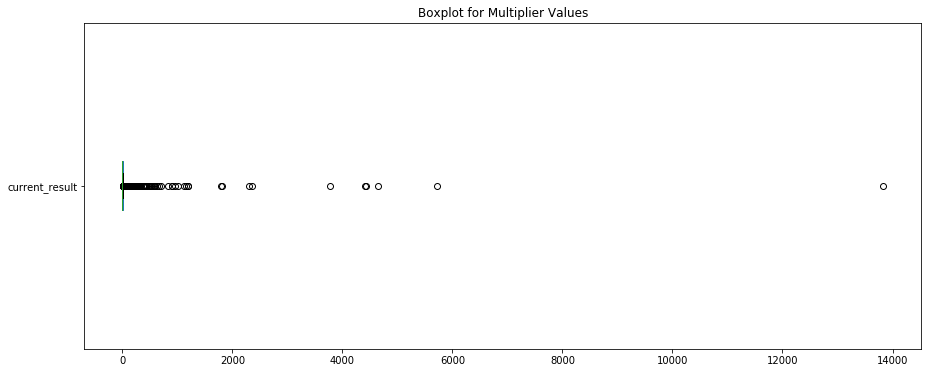

In [23]:
import matplotlib.pyplot as plt

plt.title('Boxplot for Multiplier Values')
plt.rcParams["figure.figsize"] = (15,6)
df['current_result'].plot.box(vert=False)

current_result
(1, 2]        6824
(2, 3]        2314
(3, 4]        1243
(4, 5]         678
(5, 6]         474
(6, 7]         299
(7, 8]         208
(8, 9]         181
(9, 14000]    1574
dtype: int64


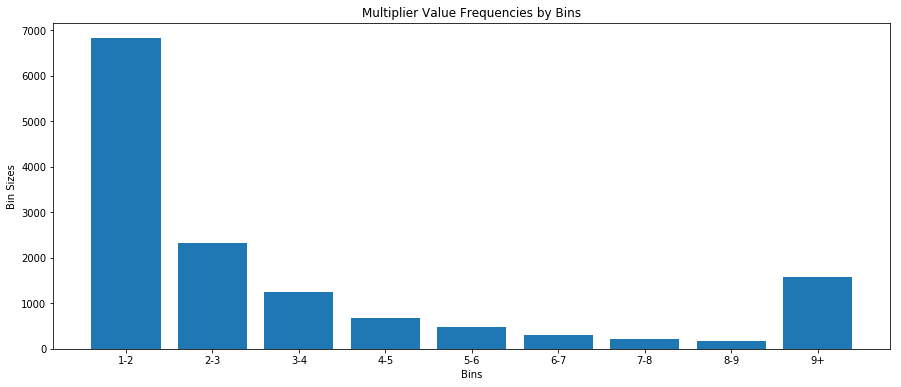

In [24]:
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 14000]

print(df.groupby(pd.cut(df['current_result'], bins=bins)).size())

bin_sizes = [bin_size for bin_size in df.groupby(pd.cut(df['current_result'], bins=bins)).size()]
y_values = bin_sizes
N = len(y_values)
x_values = range(N)

plt.title('Multiplier Value Frequencies by Bins')
plt.xlabel('Bins')
plt.ylabel('Bin Sizes')
plt.bar(x_values, y_values)
plt.xticks(x_values, ('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9+'))
plt.rcParams["figure.figsize"] = (15,6)
plt.show()

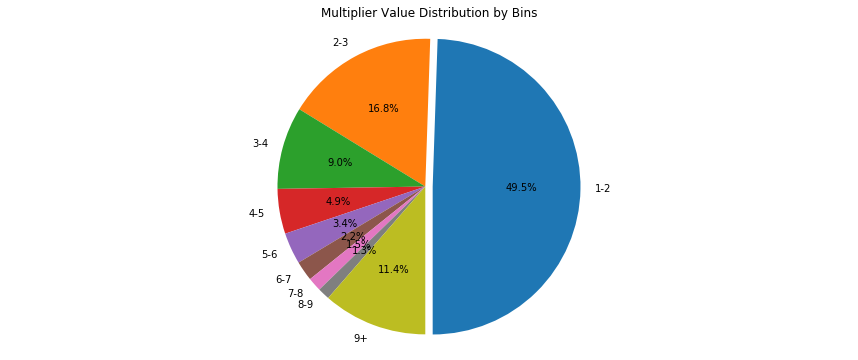

In [25]:
labels = '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9+'
sizes = bin_sizes
explode = (0.05, 0, 0, 0, 0, 0, 0, 0, 0)
 
plt.title('Multiplier Value Distribution by Bins')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=-90)
plt.axis('equal')
plt.rcParams["figure.figsize"] = (15,6)
plt.show()

In [26]:
print('Sudden busts: ' + str(round(len([m for m in y if m == 1]) / len(y) * 100, 2)) + '%')

Sudden busts: 1.87%


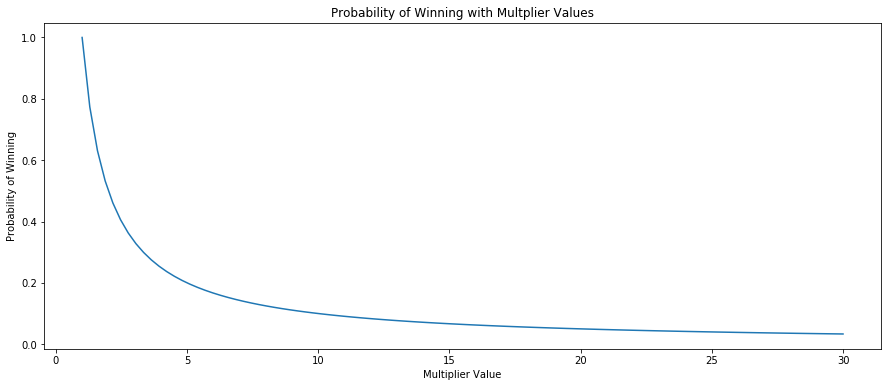

In [37]:
plt.title('Probability of Winning with Multplier Values')
plt.xlabel('Multiplier Value')
plt.ylabel('Probability of Winning')
x = np.linspace(1,30,100)
plt.plot(x, 1/x)
plt.show()

### 3.2 Applying machine learning tools

In [28]:
# Importing regression modules
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neural_network import MLPRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import SGDRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn import svm

# Importing necessary tools
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

C:\Users\josed\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\josed\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [29]:
# Defining a helper function
def frange(x, y, jump):
    """
    range() equivalent for floats.
    """
    while x < y:
        yield x
        x += jump

### 3.2.1 KNeighborsRegressor

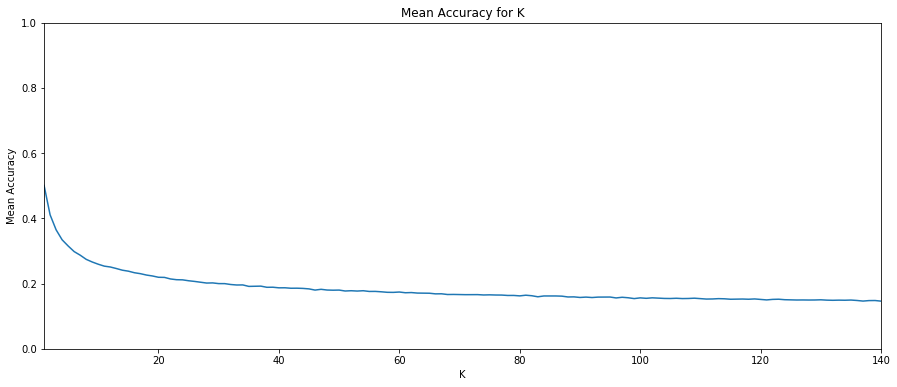

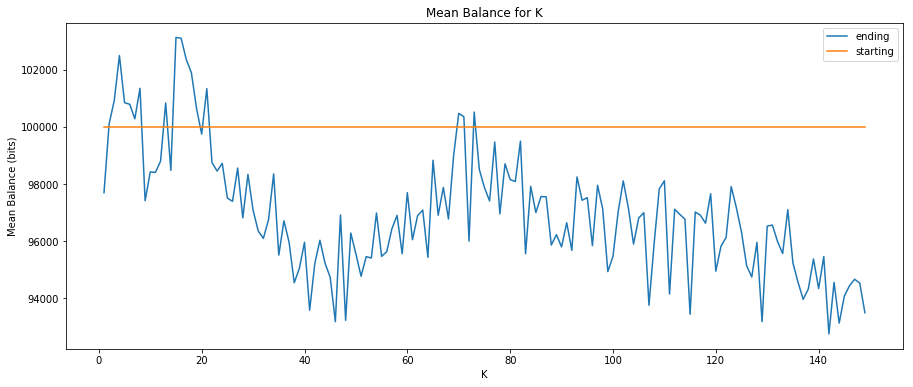

Maximum average accuracy: 50.09% at K = 1
Maximum ending balance: 103128.89 bits at K = 14


In [30]:
kf = KFold(n_splits=10, shuffle=True)

array_of_accuracies = []
array_of_balances = []

start = 1
step  = 1
end   = 150

for K in range(start, end, step):
    model = KNeighborsRegressor(n_neighbors=K)
    
    accuracies = []
    balances = []
    y_pred = []
    
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        count = 0
        balance = 100000.00
        for i in range(len(y_test)):
            if y_pred[i] <= y_test[i] and y_pred[i] >= 1:
                count += 1
                balance += float(y_pred[i]) * 100 - 100
            else:
                balance -= 100

        accuracy = count / len(y_pred)
        accuracies = np.append(accuracies, accuracy)
        balances = np.append(balances, balance)

    average_ending_balance = np.mean(balances)
    average_accuracy = np.mean(accuracies)
    
    array_of_accuracies = np.append(array_of_accuracies, average_accuracy)
    array_of_balances = np.append(array_of_balances, average_ending_balance)

num_neighbors_used = [K for K in list(range(start, end, step))]

plt.title("Mean Accuracy for K")
plt.xlabel('K')
plt.ylabel('Mean Accuracy')
plt.ylim(0.0, 1.0)
plt.xlim(1, 140)
plt.plot(num_neighbors_used, array_of_accuracies)
plt.show()

plt.title("Mean Balance for K")
plt.xlabel('K')
plt.ylabel('Mean Balance (bits)')
plt.plot(num_neighbors_used, array_of_balances, label='ending')
plt.plot(num_neighbors_used, np.full(int((end - start) / step), 100000), label='starting')
plt.legend(loc='upper right')
plt.show()

max_accuracy_KNN = array_of_accuracies[array_of_balances.argmax()]
max_balance_KNN = np.max(array_of_balances)

print("Maximum average accuracy: " + str(round(np.max(array_of_accuracies) * 100, 2)) + '% at K = ' + str(array_of_accuracies.argmax() + 1))
print("Maximum ending balance: " + str(round(max_balance_KNN, 2)) + ' bits at K = ' + str(array_of_balances.argmax()))

### 3.2.2 RANSACRegressor

Random Sample Consensus. 

RANSAC is a non-deterministic, iterative algorithm that estimates the parameter of a (supervised) machine learning algorithm from a data set that contains outliers.

In [31]:
kf = KFold(n_splits=10, shuffle=True)

array_of_accuracies = []
array_of_balances = []

model = linear_model.RANSACRegressor()

accuracies = []
balances = []
y_pred = []

for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    count = 0
    balance = 100000.00
    for i in range(len(y_test)):
        if y_pred[i] <= y_test[i] and y_pred[i] >= 1:
            count += 1
            balance += float(y_pred[i]) * 100 - 100
        else:
            balance -= 100

    accuracy = count / len(y_pred)
    accuracies = np.append(accuracies, accuracy)
    balances = np.append(balances, balance)

average_ending_balance = np.mean(balances)
average_accuracy = np.mean(accuracies)

array_of_accuracies = np.append(array_of_accuracies, average_accuracy)
array_of_balances = np.append(array_of_balances, average_ending_balance)

max_accuracy_RANSAC = np.max(array_of_accuracies)
max_balance_RANSAC = np.max(array_of_balances)

print("Maximum ending accuracy: " + str(round(max_accuracy_RANSAC * 100, 2)) + "%")
print("Maximum ending balance:" + str(round(max_balance_RANSAC, 2)) + ' bits')

Maximum ending accuracy: 55.7%
Maximum ending balance:85553.17 bits


### 3.2.3 Ridge

In [32]:
kf = KFold(n_splits=10, shuffle=True)

array_of_accuracies = []
array_of_balances = []

model = linear_model.Ridge(alpha=0.5) 

accuracies = []
balance_array = []
y_pred = []

for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    count = 0
    balance = 100000.00
    for i in range(len(y_test)):
        if y_pred[i] <= y_test[i] and y_pred[i] >= 1:            
            count += 1
            balance += float(y_pred[i]) * 100 - 100
        else:
            balance -= 100

    accuracy = count / len(y_pred)
    accuracies = np.append(accuracies, accuracy)
    balance_array = np.append(balance_array, balance)

average_ending_balance = np.mean(balance_array)
average_accuracy = np.mean(accuracies)

array_of_accuracies = np.append(array_of_accuracies, average_accuracy)
array_of_balances = np.append(array_of_balances, average_ending_balance)

max_accuracy_Ridge = np.max(array_of_accuracies)
max_balance_Ridge = np.max(array_of_balances)

print("Maximum ending accuracy: " + str(round(max_accuracy_Ridge * 100, 2)) + "%")
print("Maximum ending balance: " + str(round(max_balance_Ridge, 2)) + ' bits')

Maximum ending accuracy: 10.07%
Maximum ending balance: 100036.41 bits


### 3.2.4 Lasso

In [33]:
kf = KFold(n_splits=10, shuffle=True)

array_of_accuracies = []
array_of_balances = []

model = linear_model.Lasso()

accuracies = []
balance_array = []
y_pred = []
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)
    
    count = 0
    balance = 100000.00
    for i in range(len(y_test)):
        if y_pred[i] <= y_test[i] and y_pred[i] >= 1:
            count += 1
            balance += float(y_pred[i]) * 100 - 100
        else:
            balance -= 100

    accuracy = count / len(y_pred)
    accuracies = np.append(accuracies, accuracy)
    balance_array = np.append(balance_array, balance)

average_ending_balance = np.mean(balance_array)
average_accuracy = np.mean(accuracies)

array_of_accuracies = np.append(array_of_accuracies, average_accuracy)
array_of_balances = np.append(array_of_balances, average_ending_balance)

max_accuracy_Lasso = np.max(array_of_accuracies)
max_balance_Lasso = np.max(array_of_balances)

print("Maximum ending accuracy: " + str(round(max_accuracy_Lasso * 100, 2)) + "%")
print("Maximum ending balance: " + str(round(max_balance_Lasso, 2)) + ' bits')

Maximum ending accuracy: 9.85%
Maximum ending balance: 101296.45 bits


### 3.2.5 A different approach: a magic number

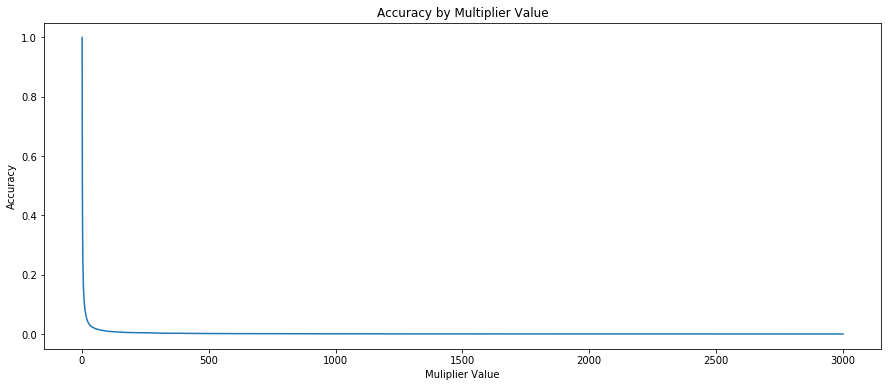

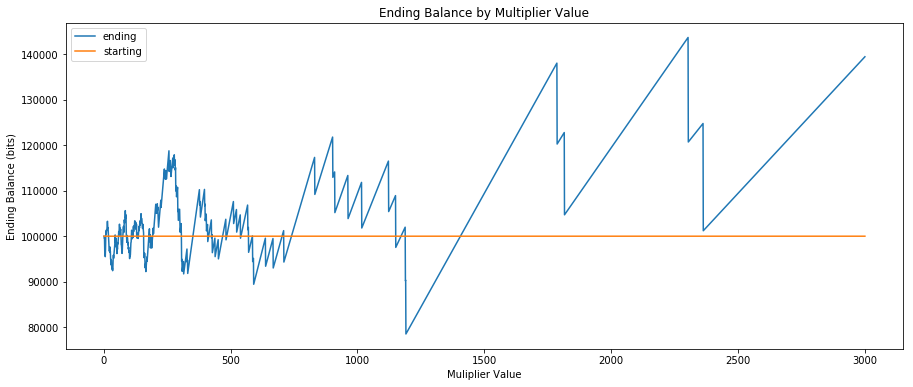

Maximum ending balance: 143660.0 bits


In [34]:
kf = KFold(n_splits=10, shuffle=True)

array_of_accuracies = []
array_of_balances = []

start = 0
step = 100
end = 300000

for i in range(start, end, step):
    accuracies = []
    balance_array = []
    y_pred = []
    
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        y_pred = np.full(len(y_test), 1 + i / 100)
        
        count = 0
        balance = 100000.00
        for j in range(len(y_test)):
            if y_pred[j] <= y_test[j] and y_pred[j] >= 1:
                count += 1
                balance += float(y_pred[j]) * 100 - 100
            else:
                balance -= 100

        accuracy = count / len(y_pred)
        accuracies = np.append(accuracies, accuracy)
        balance_array = np.append(balance_array, balance)

    average_ending_balance = np.mean(balance_array)
    average_accuracy = np.mean(accuracies)
    
    array_of_accuracies = np.append(array_of_accuracies, average_accuracy)
    array_of_balances = np.append(array_of_balances, average_ending_balance)

numbers_list = list(frange(1 + start / 100, 1 + end / 100 - 0.01, round(step / 100, 2)))
numbers_array = [round(elem, 2) for elem in numbers_list]

plt.plot(numbers_array, array_of_accuracies)
plt.title("Accuracy by Multiplier Value")
plt.xlabel('Muliplier Value')
plt.ylabel('Accuracy')
plt.show()

plt.title("Ending Balance by Multiplier Value")
plt.xlabel('Muliplier Value')
plt.ylabel('Ending Balance (bits)')
plt.plot(numbers_array, array_of_balances, label='ending')
plt.plot(numbers_array, np.full(int((end - start) / step), 100000), label='starting')
plt.legend(loc='upper left')
plt.show()

max_accuracy_MN = array_of_accuracies[array_of_balances.argmax()]
max_balance_MN = np.max(array_of_balances)

print("Maximum ending balance: " + str(round(np.max(array_of_balances), 2)) + ' bits')

## 4. Results

### 4.1 Individual results

Please see above for individual results.

### 4.2 Cumulative results

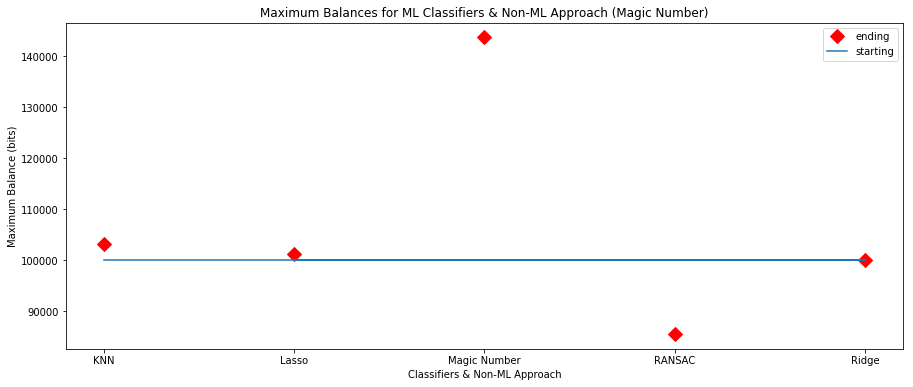

In [35]:
x = ["KNN", "RANSAC", "Ridge", "Lasso", "Magic Number"]
y = [max_balance_KNN, max_balance_RANSAC, max_balance_Ridge, max_balance_Lasso, max_balance_MN]
x, y = zip(*sorted(zip(x, y),key=lambda x: x[0]))

plt.title("Maximum Balances for ML Classifiers & Non-ML Approach (Magic Number)")
plt.xlabel('Classifiers & Non-ML Approach')
plt.ylabel('Maximum Balance (bits)')
plt.plot(x, y, 'rD', markersize=10, label='ending')
plt.plot(["KNN", "RANSAC", "Ridge", "Lasso", "Magic Number"], np.full(5, 100000), label='starting')
plt.legend(loc='upper right')
plt.show()

## 5. Conclusions & 6. Lessons learned

* Randomness
    - No such thing as “true randomness"
    - **Secondary objective**: gain some insight into the random algorithm *bustabit* uses for their game
* Approaching it differently: *a magic number*
* Defining success
    - Important to understand problem space
    - Initial guess: anything above 50% accuracy successful
    - Different problems require different solutions
    - Different problems require different metrics for success
* Accuracy and results
    - High accuracy did not mean the best results
    - Non-machine learning approach yielded the best results